# Working interface models

In [13]:
%matplotlib widget
import time
from bmcs_expsim.utils.mlab_decorators import decorate_figure
from mayavi import mlab
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import warnings
import matplotlib.pylab as plt
import numpy as np
from ibvpy.api import TStepBC , TFCyclicNonsymmetricConstant, TFBilinear
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_interface import XDomainFEInterface
from ibvpy.fets import FETS2D4Q
from ibvpy.fets.fets1D5 import FETS1D52ULRH
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from bmcs_matmod.slide.vslide_34_TN_axisym import Slide34
from ibvpy.tmodel.mats3D.mats3D_elastic.vmats3D_elastic import \
    MATS3DElastic
from ibvpy.tmodel.mats2D.mats2D_elastic.vmats2D_elastic import \
    MATS2DElastic

# FE 2D discretization

In [14]:
n_y_e = 2
n_inner_x_e = 1
n_outer_x_e = 1
L_x = 1.0
P = 1.0
R_in = 10 / (2 * np.pi) 
R_out = 2 * R_in
xd_lower = XDomainFEGrid(integ_factor = P,
                         coord_min=(0, 0),
                          coord_max=(L_x, R_in),
                          shape=(n_y_e, n_inner_x_e),
                          fets=FETS2D4Q())
xd_upper = XDomainFEGrid(integ_factor = P,
                         coord_min=(0, R_in),
                          coord_max=(L_x, R_out),
                          shape=(n_y_e, n_outer_x_e),
                          fets=FETS2D4Q())
m1 = MATS2DElastic(E=37000, nu=0.18)
m2 = MATS2DElastic(E=37000, nu=0.18)

xd12 = XDomainFEInterface(
    integ_factor = P,
    I=xd_lower.mesh.I[:, -1],
    J=xd_upper.mesh.I[:, 0],
    fets=FETS1D52ULRH()
)

In [15]:
material_params =  dict(
     E_T=1, gamma_T=500, K_T=0, S_T=0.5, c_T=6, bartau=3, 
     E_N=1, S_N=0.5, c_N = 3, m = 0.05, f_t=2, f_c=60, f_c0 = 40, eta=0.)
bond_m = Slide34(**material_params)

In [11]:
m = TStepBC(
    domains=[(xd_lower, m1),
             (xd_upper, m2),
             (xd12, bond_m),
             ]
)

In [12]:
xd12.I.dofs, xd12.J.dofs

(array([[ 2,  3],
        [ 6,  7],
        [10, 11]]),
 array([[12, 13],
        [16, 17],
        [20, 21]]))

## Compression/Traction fc

In [5]:
lower_fixed_1 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
lower_fixed_0 = BCSlice(slice=xd_lower.mesh[0, 0, 0, 0], var='u', dims=[0], value=0)

upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
         var='u', dims=[1], value=0.01)

compression_dofs = upper_compression_slice.dofs
compression = -20 / len(compression_dofs)
upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression) 
             for dof in compression_dofs ]
bc1 = [lower_fixed_0, lower_fixed_1] + upper_compression_force_first

## Sliding dc

In [6]:
#lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
#upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)
#
#lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=6)
#
#
#bc1 =   [lower_fixed_0, upper_fixed_1, lower_slide]

## Sliding fc

In [7]:
#lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
#upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)
#
#
#
#lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=0)
#Force = 4 / len(lower_slide.dofs)
#lower_slide_force = [BCDof(var='f', dof=dof, value = Force) 
#             for dof in lower_slide.dofs]
#
#bc1 =   [lower_fixed_0, upper_fixed_1] + lower_slide_force

In [8]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 1000
s.tline.step = 0.1
s.tstep.fe_domain.serialized_subdomains

In [10]:
xd_lower.mesh.dofs

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [11]:
xd_upper.mesh.dofs

array([[ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15]])

In [9]:
xd12.hidden = True
s.reset()
s.run()

t:	 0.00(0), 
	 0.10(1), 
	 0.20(1), 
	 0.30(1), 
	 0.40(1), 
	 0.50(1), 
	 0.60(1), 
	 0.70(1), 
	 0.80(1), 
	 0.90(1), 
	 1.00(1), 



In [10]:
states_t = [states_t[2] for states_t in m.hist.state_vars]
var_names = states_t[0].keys()
EpsSig_t = {
    var_name: np.array([ state_dict[var_name] for state_dict in states_t ]) 
    for var_name in var_names 
}
u_pi_N = EpsSig_t['w_pi']
u_pi_Tx = EpsSig_t['s_pi_x']
sig_pi_N = EpsSig_t['sig_pi']
sig_pi_Tx = EpsSig_t['tau_pi_x']
sig_pi_Ty = EpsSig_t['tau_pi_y']
omega_Nx = EpsSig_t['omega_N']
omega_Tx = EpsSig_t['omega_T']
x_m = xd12.x_Eia[:,:,0].flatten()

In [11]:
xd12.o_Epia

array([[[[ 2,  3],
         [ 6,  7]],

        [[ 8,  9],
         [12, 13]]]])

In [12]:
U_last = m.hist.U_t[-1]
U_last[xd12.o_Epia]

array([[[[ 1.06443751e-15, -8.60296990e-04],
         [ 9.72972973e-05, -8.60296990e-04]],

        [[ 3.96031070e-13, -2.00008603e+01],
         [ 9.72972977e-05, -2.00008603e+01]]]])

In [13]:
xd12.map_U_to_field(U_last)

array([[[ 3.94966632e-13, -2.00000000e+01],
        [ 3.94808982e-13, -2.00000000e+01]]])

In [14]:
time = m.hist.t
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
ax1.plot(time, sig_pi_N[:,0,0].flatten(), label='sigma')
ax1.plot(time, sig_pi_N[:,0,1].flatten(), label='sigma')
ax1.set_xlabel('time')
ax1.set_ylabel('normal stress')
ax1.legend()

ax2.plot(time, sig_pi_Tx[:,0,0].flatten(), color='red', label='tau')
ax2.set_xlabel('time')
ax2.set_ylabel('tangential stress')
ax2.legend()

ax3.plot(time, omega_Nx[:,0,0].flatten(), color='red', label='normal damage')
ax3.plot(time, omega_Tx[:,0,0].flatten(), color='green', label='tangential damage')

ax3.set_xlabel('time')
ax3.set_ylabel('damage')
ax3.legend()

ax4.plot(time, u_pi_N[:,0,0].flatten(), color='red', label='opening')
ax4.set_xlabel('time')
ax4.set_ylabel('opening')
ax4.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [66]:
sig_pi_N.shape

(11, 1, 2)

In [67]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

ERROR|2021-10-14 11:44:17,647|Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001C33ACF7E50>, trait: data_range, old value: [0. 0.], new value: [  0. -20.]
Traceback (most recent call last):
  File "C:\Users\marag\miniconda3\envs\bmcs_env\lib\site-packages\traits\trait_notifiers.py", line 342, in __call__
    self.handler(*args)
  File "C:\Users\marag\miniconda3\envs\bmcs_env\lib\site-packages\mayavi\core\lut_manager.py", line 434, in _data_range_changed
    assert value[0] <= value[1]
AssertionError


# FE Axisymmetric discretization

In [33]:
n_y_e = 1
n_inner_x_e = 1
n_outer_x_e = 1
L_x = 1.0
P = 1.0
R_in = P / (2 * np.pi) 
R_out = 2 * R_in
xd_lower = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                         coord_min=(0, 0),
                          coord_max=(L_x, R_in),
                          shape=(n_y_e, n_inner_x_e),
                          fets=FETS2D4Q())
xd_upper = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                         coord_min=(0, R_in),
                          coord_max=(L_x, R_out),
                          shape=(n_y_e, n_outer_x_e),
                          fets=FETS2D4Q())
m1 = MATS3DElastic(E=37000, nu=0.18)
m2 = MATS3DElastic(E=37000, nu=0.18)

xd12 = XDomainFEInterface(
    integ_factor =  2 * np.pi * R_in,
    I=xd_lower.mesh.I[:, -1],
    J=xd_upper.mesh.I[:, 0],
    fets=FETS1D52ULRH()
)

In [34]:
material_params =  dict(
     E_T=1, gamma_T=500, K_T=0, S_T=0.5, c_T=6, bartau=3, 
     E_N=1, S_N=0.5, c_N = 3, m = 0.05, f_t=2, f_c=60, f_c0 = 40, eta=0.)
bond_m = Slide34(**material_params)

In [35]:
m = TStepBC(
    domains=[(xd_lower, m1),
             (xd_upper, m2),
             (xd12, bond_m),
             ]
)

## Compression/Traction fc

In [36]:
lower_fixed_1 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
lower_fixed_0 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)

upper_compression_slice = BCSlice(slice=xd_upper.mesh[:, -1, :, -1],
         var='u', dims=[1], value=0.01)

compression_dofs = upper_compression_slice.dofs
compression = -20 / len(compression_dofs)
upper_compression_force_first = [BCDof(var='f', dof=dof, value = compression) 
             for dof in compression_dofs ]
bc1 = [lower_fixed_0, lower_fixed_1] + upper_compression_force_first

## Sliding dc

In [37]:
#lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
#upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)
#
#lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=6)
#
#
#bc1 =   [lower_fixed_0, upper_fixed_1, lower_slide]

## Sliding fc

In [38]:
#lower_fixed_0 = BCSlice(slice=xd_lower.mesh[:, 0, :, 0], var='u', dims=[1], value=0)
#upper_fixed_1 = BCSlice(slice=xd_upper.mesh[0, :, 0, :], var='u', dims=[0], value=0)
#
#
#
#lower_slide = BCSlice(slice=xd_lower.mesh[0, :, 0, :], var='u', dims=[0], value=0)
#Force = 10 / len(lower_slide.dofs)
#lower_slide_force = [BCDof(var='f', dof=dof, value = Force) 
#             for dof in lower_slide.dofs]
#
#bc1 =   [lower_fixed_0, upper_fixed_1] + lower_slide_force

In [39]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 1000
s.tline.step = 0.1
s.tstep.fe_domain.serialized_subdomains

In [40]:
#bond_m.interact()

In [41]:
xd12.hidden = True
s.reset()
s.run()

t:	 0.00(0), 
	 0.10(1), 
	 0.20(1), 
	 0.30(1), 
	 0.40(1), 
	 0.50(1), 
	 0.60(1), 
	 0.70(1), 
	 0.80(1), 
	 0.90(1), 
	 1.00(1), 



In [42]:
states_t = [states_t[2] for states_t in m.hist.state_vars]
var_names = states_t[0].keys()
EpsSig_t = {
    var_name: np.array([ state_dict[var_name] for state_dict in states_t ]) 
    for var_name in var_names 
}
u_pi_N = EpsSig_t['w_pi']
u_pi_Tx = EpsSig_t['s_pi_x']
sig_pi_N = EpsSig_t['sig_pi']
sig_pi_Tx = EpsSig_t['tau_pi_x']
sig_pi_Ty = EpsSig_t['tau_pi_y']
omega_Nx = EpsSig_t['omega_N']
omega_Tx = EpsSig_t['omega_T']
x_m = xd12.x_Eia[:,:,0].flatten()

In [43]:
xd12.o_Epia

array([[[[ 2,  3],
         [ 6,  7]],

        [[ 8,  9],
         [12, 13]]]])

In [44]:
U_last = m.hist.U_t[-1]
U_last[xd12.o_Epia]

array([[[[ 6.51531806e-05, -7.03709651e-10],
         [ 6.51661469e-05, -6.96591866e-10]],

        [[ 0.00000000e+00, -1.09004725e-04],
         [ 1.30319328e-04, -1.08272374e-04]]]])

In [45]:
xd12.map_U_to_field(U_last)

array([[[-6.51531806e-05, -1.09004021e-04],
        [ 6.51531806e-05, -1.08271677e-04]]])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
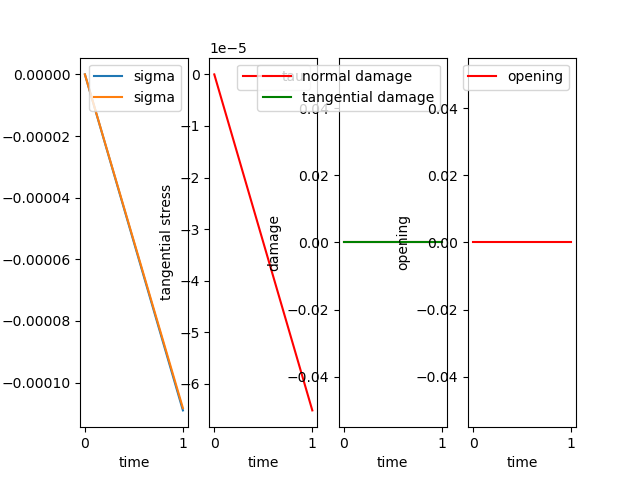

In [46]:
time = m.hist.t
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
ax1.plot(time, sig_pi_N[:,0,0].flatten(), label='sigma')
ax1.plot(time, sig_pi_N[:,0,1].flatten(), label='sigma')
ax1.set_xlabel('time')
ax1.set_ylabel('normal stress')
ax1.legend()

ax2.plot(time, sig_pi_Tx[:,0,0].flatten(), color='red', label='tau')
ax2.set_xlabel('time')
ax2.set_ylabel('tangential stress')
ax2.legend()

ax3.plot(time, omega_Nx[:,0,0].flatten(), color='red', label='normal damage')
ax3.plot(time, omega_Tx[:,0,0].flatten(), color='green', label='tangential damage')

ax3.set_xlabel('time')
ax3.set_ylabel('damage')
ax3.legend()

ax4.plot(time, u_pi_N[:,0,0].flatten(), color='red', label='opening')
ax4.set_xlabel('time')
ax4.set_ylabel('opening')
ax4.legend()

In [47]:
sig_pi_N.shape

(11, 1, 2)

In [48]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()